# Agent 0 vs Agent 1: Performance Comparison

In this experiment, we compare **Agent 0 (baseline A2C, n=1)** with **Agent 1 (A2C with stochastic rewards, n=1)**.  

Key points about the agents:

- **Agent 0 (n=1)**: Standard A2C with deterministic rewards, serves as the baseline for performance evaluation.
- **Agent 1 (n=1, Stochastic Rewards)**: Introduces reward masking with probability 0.9 during learning. True episodic returns are logged for evaluation. The stochastic rewards are intended to simulate a noisy environment, which can make learning more challenging.

The comparison is based on:

- **Evaluation Returns** (mean, std, min, max)
- **Estimated Value Functions V(s)**
- **Seeds achieving high performance (≥ 450 return)**

All metrics are aggregated over 3 random seeds to account for variability in learning.


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("results")
SAVE_DIR.mkdir(exist_ok=True)

In [2]:
# --------------------------
# LOAD AGENT 0
# --------------------------
with open("/workspaces/codespaces-blank/agent1/agent0_multi_seed_results.pkl", "rb") as f:
    agent0_results = pickle.load(f)

agent0_histories = []
for seed, data in agent0_results.items():
    eval_log = data['eval_log']
    steps = eval_log['steps']
    rewards = eval_log['mean_returns']
    values = [np.mean(v) for v in eval_log['value_trajectories']]
    agent0_histories.append({
        "train_steps": steps,
        "train_rewards": rewards,
        "mean_values": values
    })

# --------------------------
# LOAD AGENT 1
# --------------------------
agent1_histories = []
for seed in range(3):
    path = f"agent1_results/history_seed{seed}.pkl"
    with open(path, "rb") as f:
        hist = pickle.load(f)
        agent1_histories.append({
            "train_steps": hist["train_steps"],
            "train_rewards": hist["train_rewards"],
            "mean_values": hist["mean_value"]  # Agent1 logs mean_value per step
        })


In [3]:
# --------------------------
# AGGREGATE FUNCTION
# --------------------------
def aggregate_across_seeds(histories, key_x="train_steps", key_y="train_rewards"):
    min_len = min(len(h[key_y]) for h in histories)
    steps = histories[0][key_x][:min_len]
    values = np.array([h[key_y][:min_len] for h in histories])
    mean_vals = np.mean(values, axis=0)
    std_vals = np.std(values, axis=0)
    return steps, mean_vals, std_vals

# --------------------------
# AGGREGATE DATA
# --------------------------
steps0, rewards0_mean, rewards0_std = aggregate_across_seeds(agent0_histories)
steps1, rewards1_mean, rewards1_std = aggregate_across_seeds(agent1_histories)
_, values0_mean, values0_std = aggregate_across_seeds(agent0_histories, key_y="mean_values")
_, values1_mean, values1_std = aggregate_across_seeds(agent1_histories, key_y="mean_values")


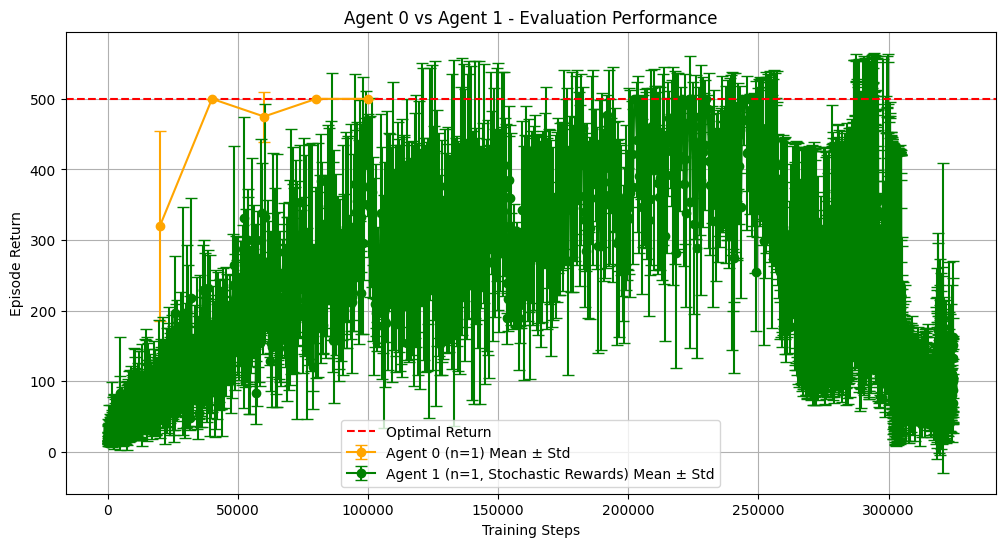

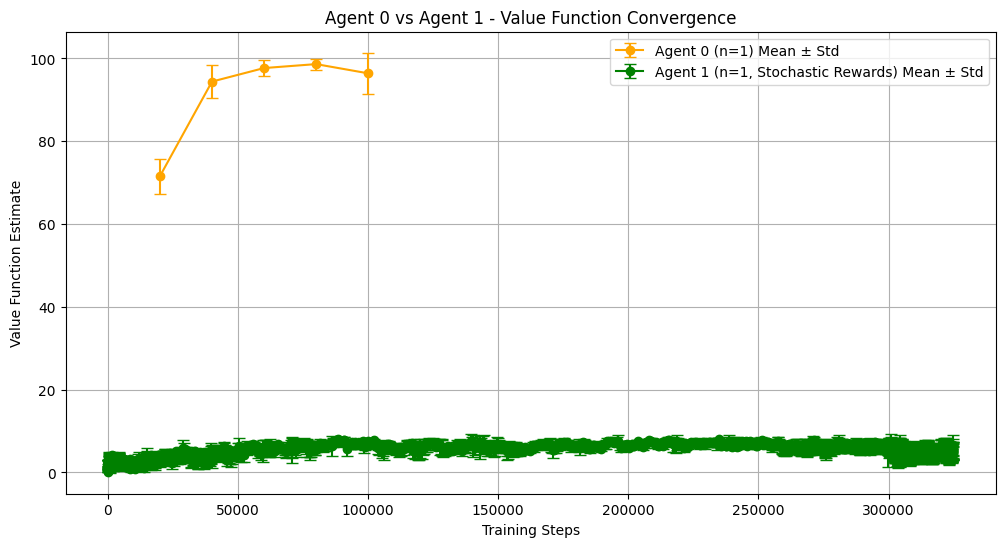

In [4]:
# --------------------------
# PLOT TRAINING REWARDS
# --------------------------
plt.figure(figsize=(12,6))
plt.errorbar(steps0, rewards0_mean, yerr=rewards0_std, color="orange",
             marker='o', capsize=4, label="Agent 0 (n=1) Mean ± Std")
plt.errorbar(steps1, rewards1_mean, yerr=rewards1_std, color="green",
             marker='o', capsize=4, label="Agent 1 (n=1, Stochastic Rewards) Mean ± Std")
plt.axhline(500, color="red", linestyle="--", label="Optimal Return")
plt.xlabel("Training Steps")
plt.ylabel("Episode Return")
plt.title("Agent 0 vs Agent 1 - Evaluation Performance")
plt.legend()
plt.grid(True)
plt.savefig(SAVE_DIR / "agent0_vs_agent1_rewards.png", dpi=200)
plt.show()

# --------------------------
# PLOT VALUE FUNCTION
# --------------------------
plt.figure(figsize=(12,6))
plt.errorbar(steps0, values0_mean, yerr=values0_std, color="orange",
             marker='o', capsize=4, label="Agent 0 (n=1) Mean ± Std")
plt.errorbar(steps1, values1_mean, yerr=values1_std, color="green",
             marker='o', capsize=4, label="Agent 1 (n=1, Stochastic Rewards) Mean ± Std")
plt.xlabel("Training Steps")
plt.ylabel("Value Function Estimate")
plt.title("Agent 0 vs Agent 1 - Value Function Convergence")
plt.legend()
plt.grid(True)
plt.savefig(SAVE_DIR / "agent0_vs_agent1_values.png", dpi=200)
plt.show()


In [5]:
# --------------------------
# TEXTUAL + TABULAR SUMMARY
# --------------------------
def summarize_agent(histories, name):
    final_rewards = [h["train_rewards"][-1] for h in histories]
    final_values = [h["mean_values"][-1] for h in histories]
    
    summary = {
        "Agent": name,
        "Mean Reward": np.mean(final_rewards),
        "Std Reward": np.std(final_rewards),
        "Min Reward": np.min(final_rewards),
        "Max Reward": np.max(final_rewards),
        "Mean V(s)": np.mean(final_values),
        "Std V(s)": np.std(final_values),
        "Seeds Reaching 450+": sum(r >= 450 for r in final_rewards)
    }
    
    return summary

agent0_summary = summarize_agent(agent0_histories, "Agent 0 (n=1)")
agent1_summary = summarize_agent(agent1_histories, "Agent 1 (n=1, Stochastic Rewards)")

# Print textual summary
print("\n" + "="*60)
print("AGENT PERFORMANCE SUMMARY (Across Seeds)")
print("="*60)
for key in agent0_summary:
    print(f"{key:20s} | Agent 0: {agent0_summary[key]} | Agent 1: {agent1_summary[key]}")
print("="*60)

try:
    import pandas as pd
    df = pd.DataFrame([agent0_summary, agent1_summary])
    print("\n" + df.to_string(index=False))
except ImportError:
    pass



AGENT PERFORMANCE SUMMARY (Across Seeds)
Agent                | Agent 0: Agent 0 (n=1) | Agent 1: Agent 1 (n=1, Stochastic Rewards)
Mean Reward          | Agent 0: 500.0 | Agent 1: 135.33333333333334
Std Reward           | Agent 0: 0.0 | Agent 1: 92.57189398276107
Min Reward           | Agent 0: 500.0 | Agent 1: 63.0
Max Reward           | Agent 0: 500.0 | Agent 1: 266.0
Mean V(s)            | Agent 0: 96.39977029418947 | Agent 1: 4.970220532128426
Std V(s)             | Agent 0: 4.9744781914968526 | Agent 1: 2.1021757465174025
Seeds Reaching 450+  | Agent 0: 3 | Agent 1: 0

                            Agent  Mean Reward  Std Reward  Min Reward  Max Reward  Mean V(s)  Std V(s)  Seeds Reaching 450+
                    Agent 0 (n=1)   500.000000    0.000000       500.0       500.0  96.399770  4.974478                    3
Agent 1 (n=1, Stochastic Rewards)   135.333333   92.571894        63.0       266.0   4.970221  2.102176                    0


# Interpretation of Results

The comparison between Agent 0 and Agent 1 shows a **significant difference in performance**:

- **Agent 0** achieves perfect performance with a mean return of **500**, zero standard deviation, and all 3 seeds reaching ≥450, confirming stable learning in the deterministic reward setting.
- **Agent 1**, however, struggles under stochastic rewards:
  - Mean return drops dramatically to **135.33** with a large standard deviation (**92.57**), indicating highly variable learning outcomes across seeds.
  - No seeds achieve high returns (≥450), demonstrating that reward masking strongly impacts the agent's ability to learn an optimal policy.
  - Value function estimates are near zero (**mean V(s) ≈ 4.97**) compared to Agent 0 (**≈96.40**), reflecting that the agent fails to correctly estimate future returns under stochastic rewards.

**Conclusion**: Introducing stochastic rewards significantly increases the difficulty of the task for Agent 1. While it simulates a realistic noisy environment, it severely hampers convergence and overall performance compared to the deterministic baseline (Agent 0). This highlights the importance of robust exploration and reward estimation mechanisms in environments with unreliable or masked feedback.
